### Load libs and setup 

In [ ]:
!pip install -U -q PyDrive
!pip install git+https://github.com/keras-team/keras-tuner.git -q

In [ ]:
# Importar bibliotecas
import numpy as np
import h5py
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from matplotlib import pyplot as plt
import tensorflow as tf
import time
import datetime
import pytz
import IPython
#import kerastuner as kt

In [ ]:
# Autorizar o acesso à api do Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Load dataset

In [ ]:
dir_id = '1yIHAMfDycKJDncAocBSWJuCKqct8XG4D'
file_list = drive.ListFile({'q': f"'{dir_id}' in parents and trashed=false"}).GetList()

for f in file_list:
    downloaded = drive.CreateFile({'id':f['id']})
    downloaded.GetContentFile(f['title']) 

In [ ]:
def load_dataset():
    # load the train data
    # train_dataset = h5py.File('train_data_orig.h5', "r")
    train_dataset = h5py.File('train_data_no_rotate_32.h5', "r")

    # your train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 

    # your train set labels
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 
    
    # load the test data
    test_dataset = h5py.File('test_data_no_rotate_32.h5', "r")

    # your test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 

    # your test set labels  
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    # the list of classes
    classes = np.array(test_dataset["list_classes"][:]) 

    # reshape the test data
    train_set_y_orig = train_set_y_orig.reshape((train_set_y_orig.shape[0],1))
    test_set_y_orig = test_set_y_orig.reshape((test_set_y_orig.shape[0],1))

    # close files
    train_dataset.close()
    test_dataset.close()
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [ ]:
# Flatten the training and test images
train_x = X_train_orig.reshape(X_train_orig.shape[0], -1)
test_x = X_test_orig.reshape(X_test_orig.shape[0], -1)

In [ ]:
# Normalize image vectors
train_x = train_x.astype(np.float32)
test_x = test_x.astype(np.float32)
train_x /= 255.
test_x /= 255.

In [ ]:
# Convert training and test labels to one hot matrices
train_y = tf.keras.utils.to_categorical(Y_train_orig).squeeze()
test_y = tf.keras.utils.to_categorical(Y_test_orig).squeeze()

print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))

number of training examples = 15120
number of test examples = 2232
X_train shape: (15120, 3072)
Y_train shape: (15120, 3)
X_test shape: (2232, 3072)
Y_test shape: (2232, 3)


### Data Preview 

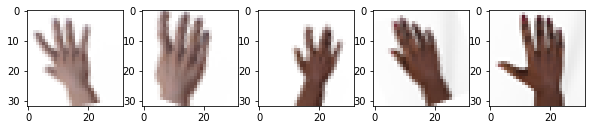

In [ ]:
# visualize a sample data
index_list = [1, 409, 864, 2242, 2400]
plt.figure(figsize=(10,10))
for i, index in enumerate(index_list):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_orig[index])
plt.show()


### Testando model

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_begin(self, batch, logs=None):
    self.begins = time.time()
    print('Training: begins at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))

  def on_train_end(self, logs=None):
    print('Training: ends at {}'.format(datetime.datetime.now(pytz.timezone('America/Fortaleza')).strftime("%Y-%m-%d %H:%M:%S")))
    print('Duration: {}s'.format(time.time() - self.begins))

In [ ]:
def print_analysis(titles,history):
  loss = ["loss", "val_loss"]
  accuracy = ["categorical_accuracy","val_categorical_accuracy"]
  f, axs = plt.subplots(1,2,figsize=(10,4))
  
  for i,item in enumerate([loss,accuracy]):
    axs[i].plot(history.history[item[0]])
    axs[i].plot(history.history[item[1]])
    axs[i].set_ylabel(item[0])
    axs[i].set_xlabel('epoch')
    axs[i].legend(['train', 'test'], loc='best')

  f.suptitle(titles, y=1.1)
  plt.tight_layout()
  plt.show()

In [ ]:
from numpy.random import seed

# Configure the random see for the reproducibility purposes
tf.random.set_seed(3)
seed(3)

# Instantiate a simple classification model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(40, activation=tf.nn.relu,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.tanh,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.Dense(24, activation=tf.nn.tanh,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.Dense(24, activation=tf.nn.tanh,kernel_initializer="he_uniform"))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax,kernel_initializer="he_uniform"))

# Instantiate a logistic loss function that expects integer targets
loss = tf.keras.losses.CategoricalCrossentropy()

# Instantiate an accuracy metric.
accuracy = tf.keras.metrics.CategoricalAccuracy()

# Instantiate an optimizer.
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.008496767471380333)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.00464309773619989)

# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

# training 
history = model.fit(x=train_x,
                    y=train_y,
                    shuffle=True,
                    batch_size=32,
                    epochs=500,
                    validation_data=(test_x,test_y),
                    callbacks=[MyCustomCallback()],
                    verbose=0)

Training: begins at 2021-03-20 18:14:02
Training: ends at 2021-03-20 18:22:57
Duration: 534.7061665058136s


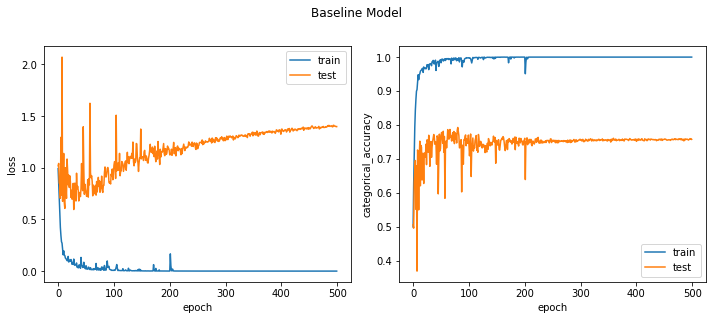

In [ ]:
print_analysis("Baseline Model", history)

In [ ]:
loss, acc = model.evaluate(x=train_x,y=train_y, batch_size=32)
print('Train loss: %.4f - acc: %.4f' % (loss, acc))

loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=32)
print('Test loss: %.4f - acc: %.4f' % (loss_, acc_))

473/473 [==============================] - 1s 2ms/step - loss: 1.2179e-04 - categorical_accuracy: 1.0000
Train loss: 0.0001 - acc: 1.0000
70/70 [==============================] - 0s 2ms/step - loss: 1.3986 - categorical_accuracy: 0.7581
Test loss: 1.3986 - acc: 0.7581


In [ ]:
print("Number of parameters %.d" % model.count_params())

Number of parameters 126691


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 40)                122920    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1312      
_________________________________________________________________
dense_14 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_16 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 75        
Total params: 126,691
Trainable params: 126,691
Non-trainable params: 0
________________________________________________

### Usando keras Tuner para descobrir os paramentros ideais

In [ ]:
from kerastuner.tuners import RandomSearch

In [ ]:
def model_builder_all(hp):
  # Instantiate a simple classification model
  model = tf.keras.Sequential()
  
  # Create a tunable number of layers 1,2,3,4
  for i in range(hp.Int('num_layers', 3, 5)):

    # Tune the number of units in the Dense layer
    # Choose an optimal value between 8-32
    model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                        min_value = 24,
                                        max_value = 48,
                                        step = 8),
                                    # Tune the activation functions
                                    activation= hp.Choice('dense_activation_' + str(i),
                                                          values=['relu', 'tanh'],
                                                          default='relu'),
                                    dtype='float64'))

  model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax, dtype='float64'))

  # Instantiate a logistic loss function that expects integer targets.
  loss = tf.keras.losses.CategoricalCrossentropy()

  # Instantiate an accuracy metric.
  accuracy = tf.keras.metrics.CategoricalAccuracy()

  opt = tf.keras.optimizers.SGD(learning_rate=hp.Float('lrate_sgd',
                                                          min_value=1e-4,
                                                          max_value=1e-2, 
                                                          sampling='LOG'))

  # configure the optimizer, loss, and metrics to monitor.
  model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

  return model

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# path to store results
LOG_DIR = f"{int(time.time())}"

In [ ]:
tuner_ = RandomSearch(model_builder_all,
                     objective='categorical_accuracy',
                     max_trials=20,  # how many model configurations would you like to test?
                     executions_per_trial=1,  # how many trials per variation? (same model could perform differently)
                     directory=LOG_DIR,
                     project_name="my_first_tuner"
                     )

In [ ]:
tuner_.search(train_x,
             train_y, 
             epochs = 250,
             # verbose = 0 (silent) 
             verbose=0,
             batch_size=32,
             validation_data = (test_x, test_y),
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_.results_summary()

Results summary
Results in 1616265680/my_first_tuner
Showing 10 best trials
Objective(name='categorical_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layers: 4
units_0: 40
dense_activation_0: relu
units_1: 32
dense_activation_1: tanh
units_2: 24
dense_activation_2: tanh
lrate_sgd: 0.00464309773619989
units_3: 32
dense_activation_3: relu
units_4: 24
dense_activation_4: tanh
Score: 1.0
Trial summary
Hyperparameters:
num_layers: 5
units_0: 48
dense_activation_0: relu
units_1: 32
dense_activation_1: relu
units_2: 32
dense_activation_2: tanh
lrate_sgd: 0.0021963029380171572
units_3: 24
dense_activation_3: tanh
units_4: 24
dense_activation_4: relu
Score: 1.0
Trial summary
Hyperparameters:
num_layers: 5
units_0: 40
dense_activation_0: relu
units_1: 32
dense_activation_1: tanh
units_2: 48
dense_activation_2: relu
lrate_sgd: 0.0014114817584581088
units_3: 24
dense_activation_3: tanh
units_4: 40
dense_activation_4: tanh
Score: 0.9998677372932434
Trial summary
Hyperparameters:
nu

In [ ]:
tuner_.get_best_hyperparameters()[0].values

{'dense_activation_0': 'relu',
 'dense_activation_1': 'tanh',
 'dense_activation_2': 'tanh',
 'dense_activation_3': 'relu',
 'dense_activation_4': 'tanh',
 'lrate_sgd': 0.00464309773619989,
 'num_layers': 4,
 'units_0': 40,
 'units_1': 32,
 'units_2': 24,
 'units_3': 32,
 'units_4': 24}

In [ ]:
tuner_.search_space_summary()

Search space summary
Default search space size: 12
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
dense_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'SGD'], 'ordered': False}
lrate_adam (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
dense_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
dense_activation_2 (Choice)
{'default': 're